In [1]:
# import torch
# import torchvision
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt

In [2]:
ct_volume = nib.load("../datasets/3702_left_knee_mask_final.nii.gz")
ct_data = ct_volume.get_fdata()

In [3]:
from scipy.ndimage import distance_transform_edt, label
from skimage.feature import peak_local_max
from skimage.segmentation import watershed

def watershed_segmentation(volume):
    """
    Applies 3D watershed segmentation to a binary volume using distance transform and local maxima.

    Parameters:
    - volume (np.ndarray): A 3D binary mask volume.

    Returns:
    - labels (np.ndarray): A 3D array of watershed-labeled regions.
    """
    # Ensure input is boolean
    binary_volume = volume.astype(bool)
    
    # Compute the Euclidean distance transform
    distance = distance_transform_edt(binary_volume)
    
    # Detect local maxima to serve as markers
    coordinates = peak_local_max(
        distance,
        footprint=np.ones((100, 100, 100)),
        labels=binary_volume,
        exclude_border=False
    )
    
    # Create marker image
    marker_mask = np.zeros(distance.shape, dtype=bool)
    marker_mask[tuple(coordinates.T)] = True
    
    # Label the markers
    markers, _ = label(marker_mask)
    
    # Apply the watershed algorithm
    labels = watershed(-distance, markers, mask=binary_volume)
    
    return labels


In [4]:
volume_3d = np.stack(ct_data, axis=0)

In [5]:
labels = watershed_segmentation(volume_3d)

In [6]:
import mayavi.mlab as mlab

mlab.contour3d(volume_3d, color=(1,1,1))
mlab.show()

In [7]:
volume_rgb = np.zeros((512, 512, 216, 3), dtype=np.uint8)

volume_rgb[labels == 0] = [255, 255, 255]
volume_rgb[labels == 1] = [0, 255, 0]
volume_rgb[labels == 2] = [255, 0, 0]

In [8]:
mlab.contour3d((labels == 1).astype(np.uint8), color=(0, 1, 0), opacity=0.5)
mlab.show()

In [9]:
volume_rgb = volume_rgb.astype(np.float32) / 255.0

In [10]:
import torch
tensor_3d = torch.from_numpy(volume_rgb).permute(3, 2, 0, 1)

In [12]:
tensor_3d.shape

torch.Size([3, 216, 512, 512])

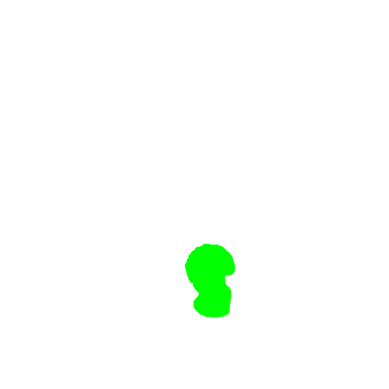

In [13]:
rgb_slice = tensor_3d[:, 100, :, :]
rgb_slice_np = rgb_slice.permute(1, 2, 0).numpy()
plt.imshow(rgb_slice_np)
plt.axis("off")
plt.show()

In [64]:
import torch
from torch import nn
import torchvision.models as models
model_2d = models.densenet121(pretrained=True)

In [65]:
model_2d.classifier = nn.Identity()

In [66]:
def inflate_conv2d(conv2d):

    in_channels = conv2d.in_channels
    out_channels = conv2d.out_channels

    k = conv2d.kernel_size[0]
    kernel_size_3d = (k, k, k)

    s = conv2d.stride[0]
    stride_3d = (s, s, s)
    
    if hasattr(conv2d, "padding") and isinstance(conv2d.padding, tuple):
        p = conv2d.padding[0]
        padding_3d = (p, p, p)
    else:
        padding_3d = 0

    conv3d = nn.Conv3d(
        in_channels=in_channels,
        out_channels=out_channels,
        kernel_size=kernel_size_3d,
        stride=stride_3d,
        padding=padding_3d,
        bias=conv2d.bias
    )

    with torch.no_grad():
        weight_2d = conv2d.weight.data
        weight_3d = weight_2d.unsqueeze(2).repeat(1, 1, k, 1, 1)/k
        conv3d.weight.data.copy_(weight_3d)
        if conv2d.bias is not None:
            conv3d.bias.data.copy_(conv2d.bias.data)
    return conv3d


In [67]:
conv0 = nn.Conv2d(3, 64, kernel_size=(7,7), stride=(2,2), padding=(3,3), bias=False)
conv3d = inflate_conv2d(conv0)

In [68]:
def inflate_batchnorm2d(bn2d):
    bn3d = nn.BatchNorm3d(
        bn2d.num_features,
        eps=bn2d.eps,
        momentum=bn2d.momentum,
        affine=bn2d.affine,
        track_running_stats=bn2d.track_running_stats
    )

    if bn2d.affine:
        with torch.no_grad():
            bn3d.weight.data.copy_(bn2d.weight.data)
            bn3d.bias.data.copy_(bn2d.bias.data)
    
    if bn2d.track_running_stats:
        bn3d.running_mean.data.copy_(bn2d.running_mean.data)
        bn3d.running_var.copy_(bn2d.running_var.data)

    return bn3d

In [69]:
norm0 = nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
norm3d = inflate_batchnorm2d(norm0)

In [70]:
def inflate_maxpool2d(maxpool2d):

    maxpool3d = nn.MaxPool3d(
        kernel_size=maxpool2d.kernel_size,
        stride=maxpool2d.stride,
        padding=maxpool2d.padding,
        dilation=maxpool2d.dilation,
        ceil_mode=maxpool2d.ceil_mode
    )

    return maxpool3d


In [71]:
pool0 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
inflate_maxpool2d(pool0)

MaxPool3d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)

In [72]:
def inflate_avgpool2d(avgpool2d):
        
    avgpool3d = nn.AvgPool3d(
        kernel_size=avgpool2d.kernel_size,
        stride=avgpool2d.stride,
        padding=avgpool2d.padding
    )

    return avgpool3d


In [73]:
conv1 = nn.AvgPool2d(kernel_size=2, stride=2, padding=0)
inflate_avgpool2d(conv1)

AvgPool3d(kernel_size=2, stride=2, padding=0)

In [74]:
def convert_densenet121(model_2d):
    for name, module in model_2d.named_children():
        # Recursively go inside children
        convert_densenet121(module)

        # Convert Conv2d → Conv3d
        if isinstance(module, nn.Conv2d):
            new_layer = inflate_conv2d(module)
            setattr(model_2d, name, new_layer)

        # Convert BatchNorm2d → BatchNorm3d
        elif isinstance(module, nn.BatchNorm2d):
            new_layer = inflate_batchnorm2d(module)
            setattr(model_2d, name, new_layer)

        # Convert MaxPool2d → MaxPool3d
        elif isinstance(module, nn.MaxPool2d):
            new_layer = inflate_maxpool2d(module)
            setattr(model_2d, name, new_layer)

        # Convert AvgPool2d → AvgPool3d
        elif isinstance(module, nn.AvgPool2d):
            new_layer = inflate_avgpool2d(module)
            setattr(model_2d, name, new_layer)

    return model_2d


In [75]:
model_3d = convert_densenet121(model_2d)

In [ ]:
tensor_3d = tensor_3d.unsqueeze(0)

In [80]:
tensor_3d.shape

torch.Size([1, 3, 216, 512, 512])

In [81]:
with torch.no_grad():
    output = model_3d(tensor_3d)

In [82]:
for name, module in model_3d.named_modules():
    if isinstance(module, nn.Conv3d):
        print(name, module)


features.conv0 Conv3d(3, 64, kernel_size=(7, 7, 7), stride=(2, 2, 2), padding=(3, 3, 3), bias=False)
features.denseblock1.denselayer1.conv1 Conv3d(64, 128, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
features.denseblock1.denselayer1.conv2 Conv3d(128, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
features.denseblock1.denselayer2.conv1 Conv3d(96, 128, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
features.denseblock1.denselayer2.conv2 Conv3d(128, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
features.denseblock1.denselayer3.conv1 Conv3d(128, 128, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
features.denseblock1.denselayer3.conv2 Conv3d(128, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
features.denseblock1.denselayer4.conv1 Conv3d(160, 128, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
features.denseblock1.denselayer4.conv2 Conv3d(128, 32, kernel_size=(3, 3, 3), stride

In [83]:
feature_maps = {}

def get_hook(name):
    def hook(module, input, output):
        feature_maps[name] = output.detach()
    return hook

In [84]:
model_3d.features.denseblock4.denselayer16.conv2.register_forward_hook(get_hook("last-convolution-layer"))
model_3d.features.denseblock4.denselayer15.conv2.register_forward_hook(get_hook("third-last-convolution-layer"))
model_3d.features.denseblock4.denselayer14.conv2.register_forward_hook(get_hook("fifth-last-convolution-layer"))

In [85]:
model_3d.eval()
with torch.no_grad():
    _ = model_3d(tensor_3d)

In [88]:
feature_maps["fifth-last-convolution-layer"].shape

torch.Size([1, 32, 6, 16, 16])

In [92]:
feature_maps["last-convolution-layer"].shape

torch.Size([1, 32, 6, 16, 16])

In [95]:
import torch.nn.functional as F

gap = F.adaptive_avg_pool3d(feature_maps["last-convolution-layer"], output_size=1)
gap = gap.view(gap.size(0), -1)
gap.shape

torch.Size([1, 32])

In [ ]:
cos_sim = F.cosine_similarity(f1, f2, dim=1)
print(f"Cosine similarity: {cos_sim.item():.4f}")